## 06. 군집화 실습 - 고객 세그먼테이션
### 고객 세그먼테이션의 정의와 기법
1. 정의 : 다양한 기준으로 고객을 분류하는 기법을 지칭
2. 활용 : CRM(Customer Relation Mangement, 고객 관계 관리)이나 마케팅의 중요 기반 요소
3. 목표 : 타겟 마케팅 - 고객 특성에 맞게 세분화해서 그 유형에 따라서 맞춤형 마케팅이나 서비스를 제공
4. 예제 : RFM 기법 사용 - Recency(R), Frequency(F), Monetary Value(M)
- Recency : 가장 최근 상품 구입 일에서 오늘까지의 시간
- Frequency : 상품 구매 횟수
- Monetary Value : 총 구매 금액

### 데이터 세트 로딩과 데이터 클렌징
- 데이터 세트 [다운로드](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx)
- 데이터 설명
    - `InvoiceNo` : 주문 번호
    - `StockCode` : 제품 코드
    - `Description` : 제품 설명
    - `Quantity` : 주문 수량
    - `InvoiceDate` : 주문 일자
    - `UnitPrice` : 제품 단가
    - `CustomerID` : 주문 고객 번호
    - `Country` : 주문 고객 국가

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
retail_df = pd.read_excel('Online Retail.xlsx')
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### 전처리
1. Qauntity > 0
2. UnitPrice > 0
3. CustomerID not null
4. Country only UK

In [26]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]

print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [27]:
retail_df.Country.value_counts().head(5)

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [28]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공
1. UnitPrice * Quantity = sale_amount (주문 금액 데이터)
2. CustomerID float → int

In [30]:
retail_df['sale_amount'] = retail_df['UnitPrice'] * retail_df['Quantity']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [33]:
# 구매 건수가 가장 많은 소비자 top5
print(retail_df['CustomerID'].value_counts().head(5), "\n")
# 주문 금액이 가장 많은 소비자 top5
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False).head(5))

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64 

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


InvoiceNo + StockCode를 식별자 사용이 가능하다.  
InvoiceNo + StockCode로 Groupby를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨

cf. 1이 되지 않는 이유는 동일한 주문에 들어있는 동일한 제품이 서로 다른 수량으로 찍혀 있을 수 있다.

In [44]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

RFM 기반 = 주문 기간, 주문 횟수, 주문 금액을 기반으로 분류  
`groupby_obj.agg()` 함수 이용 

In [78]:
# grp_obj = retail_df.groupby('CustomerID')
# cnt = grp_obj['InvoiceNo'].agg('count')
# sale_sum = grp_obj['sale_amount'].agg('sum')
# perid = grp_obj['InvoiceDate'].agg('max')

aggs = {
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}

cust_df = retail_df.groupby('CustomerID').agg(aggs)
cols = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'sale_amount':'Monetary'}
cust_df.rename(columns=cols, inplace=True)
cust_df.reset_index(inplace=True)
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


#### Recency 처리
- 온라인 판매 데이터가 2010.12.01~2011.12.09 이므로 오늘 날짜를 2011.12.10으로 지정

cf. `lambda x : x.day + 1`로 할 경우
```
'Timedelta' object has no attribute 'day'
``` 
오류 출력, apply() 함수를 쓸 때는 datetime 라이브러리 중에서 Timedelta 라는 모듈을 사용하나보다

In [79]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days +1) 
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


### RFM 기반 고객 세그먼테이션
- 소매업체의 대규모 주문을 포함하고 있기 때문에 개인 고개 주문과 매우 큰 차이를 가지며 이로 인해 매우 왜곡된 데이터 분포도를 가짐

#### histogram으로 확인

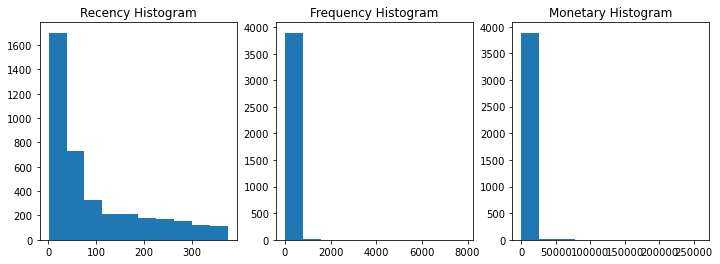

In [88]:
cols = ['Recency', 'Frequency', 'Monetary']
fig, axes = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
for i in range(3) :
    ax = axes[i]
    ax.set_title(cols[i]+' Histogram')
    ax.hist(cust_df[cols[i]])

In [82]:
cust_df[cols].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


#### skew로 왜곡된 정도 확인하기 [link](https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de)
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed

In [86]:
cust_df[cols].skew(axis=0)

Recency       1.244993
Frequency    18.668778
Monetary     20.198459
dtype: float64

- 왜곡 정도가 심한 데이터 세트에서 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행된다.
- 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import skew


X_ftrs = cust_df[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ftrs)

# 시각화
# fig, axes = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
# for i in range(3) :
#     ax = axes[i]
#     ax.set_title('Scaled '+cols[i]+' Histogram')
#     ax.hist(X_scaled[:,i])
#     print(cols[i],":\t", skew(X_scaled[:,i]))

kmeans = KMeans(n_clusters=3, random_state=0) # 군집이 3개
labels = kmeans.fit_predict(X_scaled)
cust_df['kmeans_label'] = labels

# print(labels.shape, type(labels))
# print(X_scaled.shape, type(X_scaled))

print(silhouette_score(X_scaled, labels)) 

0.5923691942714455


#### 실루엣 계수 시각화 
부록 [링크](https://github.com/wikibook/ml-definitive-guide/blob/master/7%EC%9E%A5/7-6_Clustering_Practice_Customer_Segmentation.ipynb)

In [107]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
        
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

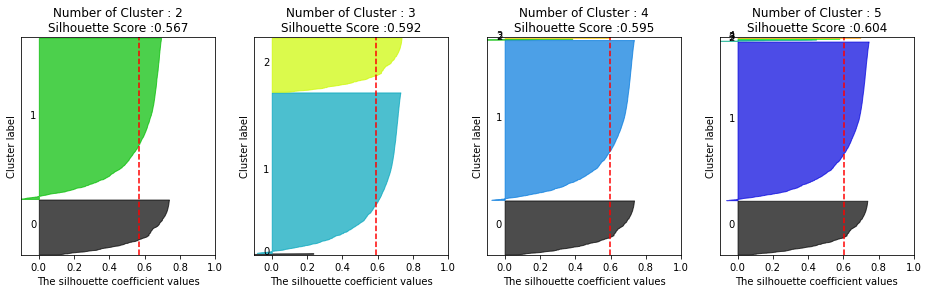

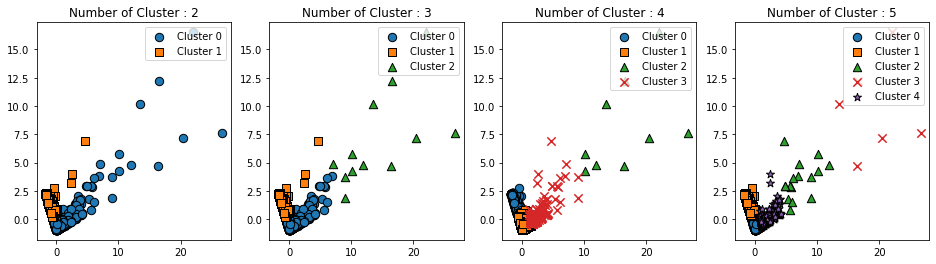

In [108]:
visualize_silhouette([2,3,4,5], X_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_scaled)

- 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어지고, 이 군집에 속한 데이터의 실루엣 계수 역시 매우 작다.
- 이러한 소수의 데이터 세트는 바로 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 건
- 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도축
- 왜곡 정도를 낮추기 위해 데이터에 로그(log)를 적용

#### 왜곡 데이터에 로그(log) 취하기

Recency_log     -0.326188
Frequency_log   -0.026017
Monetary_log     0.369572
dtype: float64


<Figure size 432x288 with 0 Axes>

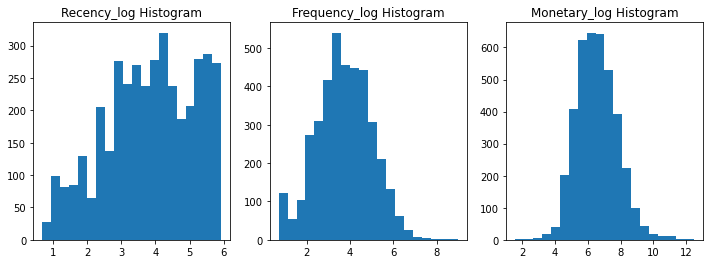

In [113]:
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

log_cols = ['Recency_log', 'Frequency_log', 'Monetary_log']

# 시각화
plt.figure()
fig, axes = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
for i in range(3):
    ax = axes[i]
    ax.set_title(log_cols[i]+" Histogram")
    ax.hist(cust_df[log_cols[i]], bins=20)

print(cust_df[log_cols].skew(axis=0))

0.30333901879711767


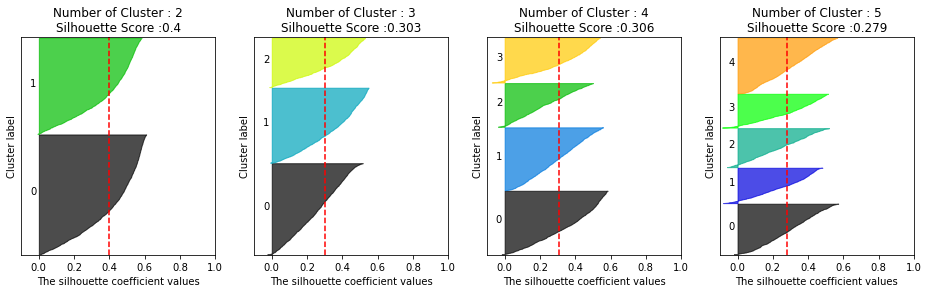

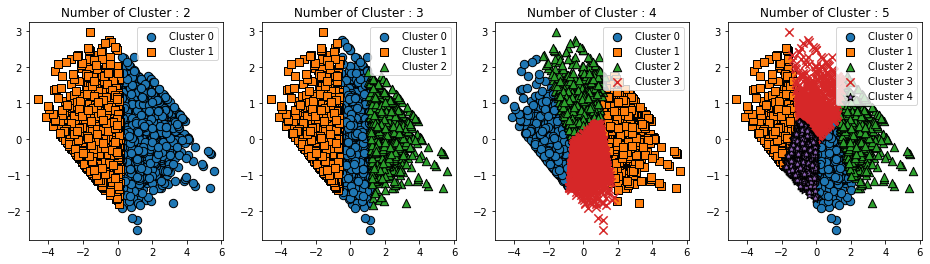

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_ftrs = cust_df[log_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ftrs)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_scaled)
cust_df['log_kmean_label'] = labels

print(silhouette_score(X_scaled, labels))

visualize_silhouette([2,3,4,5], X_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_scaled)

- 실루엣 계수는 떨어졌지만 절대치가 중요한 것이 아니라 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요
- 로그 변환하기 전보다 더 균일하게 균집화가 구성됨

#### 다른 군집화 알고리즘과 비교

In [115]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

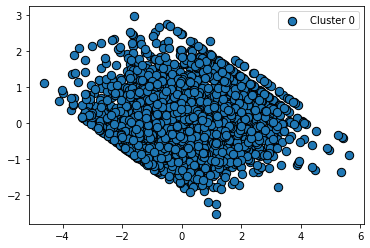

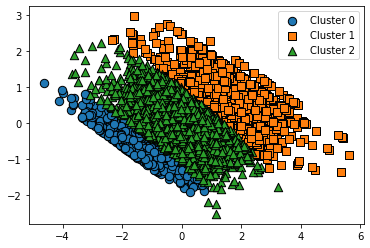

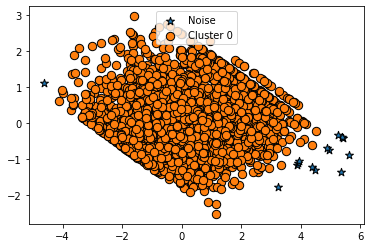

In [127]:
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cust_df[log_cols])

# PCA
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

cust_df[['ftr1','ftr2']] = X_pca

n_cluster = 3

# MeanShift
best_h = estimate_bandwidth(X_pca)
meanshift = MeanShift(bandwidth=best_h)
cust_df['log_meanshift_label'] = meanshift.fit_predict(X_pca)

# GMM
gmm = GaussianMixture(n_components=n_cluster)
cust_df['log_gmm_label'] = gmm.fit_predict(X_pca)

# DBSCAN
dbscan = DBSCAN()
cust_df['log_dbscan_label'] = dbscan.fit_predict(X_pca)

# 시각화
visualize_cluster_plot(meanshift, cust_df, 'log_meanshift_label', iscenter=False)
visualize_cluster_plot(gmm, cust_df, 'log_gmm_label', iscenter=False)
visualize_cluster_plot(dbscan, cust_df, 'log_dbscan_label', iscenter=False)

## 07. 정리

### 거리 기반 알고리즘
__1. K-평균 (KMeans)__
- 거리 기반 군집 중심점을 이동하면서 군집화 수행
- 매우 쉽고 직관적
- 원형 구조의 데이터 세트에 효과적이지만 복잡한 구조에는 한계 O
- 실루엣 계수로 평가

### 밀도 기반 알고리즘
__2. 평균 이동 (MeanShift)__
- 밀도가 가장 높은 쪽으로 군집 중심점 이동 (KDE 사용)
- 다양한 데이터 구조에 유연하게 사용 가능
- 이상치 영향 ↓, 군집 개수 지정 필요 X but bandwidth의 영향 큼
- 정형 데이터 세트보다는 컴퓨터 비전 영역에서 이미지, 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는데 효과적

__3. DBSCAN (DBSCAN)__
- 입실론 주변 영역 내에 포함되는 최소 데이터 갯수에 따라서 포인트를 구분하고 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성
- 간단하고 직관적
- 기하하적으로 복잡한 데이터세트에도 효과적

### 거리 또는 밀도 기반 X
__4. GMM__
- 데이터가 여러 개의 가우시안 분포라고 가정하고 군집화하는 방식
- K-평균보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있음
- 수행 시간이 오래 걸림

cf. [AI] Clustering (군집화) 개념과 알고리즘 종류 [링크](https://bangu4.tistory.com/98) ← 여기에 그림과 같이 핵심적으로 잘 설명이 되어있다.


#### 참고
- Online Retail Data Set [link](https://archive.ics.uci.edu/ml/datasets/online+retail)